[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)


# 链式结构

## 回顾

我们构建了一个包含节点、普通边和条件边的简单图结构。

## 目标

现在，让我们逐步构建一个结合了4个[核心概念](https://python.langchain.com/v0.2/docs/concepts/)的简单链：

* 使用[聊天消息](https://python.langchain.com/v0.2/docs/concepts/#messages)作为图状态
* 在图节点中使用[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
* 为聊天模型[绑定工具](https://python.langchain.com/v0.2/docs/concepts/#tools)
* 在图节点中[执行工具调用](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## 消息

聊天模型可以使用 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) 来记录对话中的不同角色。

LangChain 支持多种消息类型，包括 `HumanMessage`（用户消息）、`AIMessage`（AI消息）、`SystemMessage`（系统消息）和 `ToolMessage`（工具调用消息）。

这些消息类型分别表示：来自用户的消息、来自聊天模型的响应、用于指导聊天模型行为的系统指令，以及来自工具调用的消息。

让我们创建一个消息列表。

每条消息可以包含以下内容：

* `content` - 消息正文内容
* `name` - 可选参数，消息发送者名称
* `response_metadata` - 可选参数，元数据字典（例如通常由模型提供方为 `AIMessages` 填充的元数据）


In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## 聊天模型

[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)能够接收消息序列作为输入，并支持上文讨论过的多种消息类型。

可供选择的[模型种类繁多](https://python.langchain.com/v0.2/docs/concepts/#chat-models)！我们将以OpenAI为例进行演示。

请确认您的`OPENAI_API_KEY`环境变量已设置，若未设置，系统将提示您输入该密钥。


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

我们可以加载一个聊天模型，并用我们的消息列表来调用它。

可以看到结果是一个带有特定 `response_metadata` 的 `AIMessage`。


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [3]:
result

AIMessage(content='One of the best places to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. Here are some details:\n\n1. **San Juan Islands, Washington**: These islands are a renowned spot for whale watching, with orcas frequently spotted between late spring and early fall. The waters around the San Juan Islands are home to both resident and transient orca pods, making it an excellent location for sightings.\n\n2. **Puget Sound, Washington**: This area, including places like Seattle and the surrounding waters, offers additional opportunities to see orcas, particularly the Southern Resident killer whale population.\n\n3. **Olympic National Park, Washington**: The coastal areas of the park provide a stunning backdrop for spotting orcas, especially during their migration periods.\n\nWhen planning a trip for whale watching, consider peak seasons for orca activity and book tours with reputable operators who adhere to re

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 228,
  'prompt_tokens': 67,
  'total_tokens': 295,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_50cad350e4',
 'finish_reason': 'stop',
 'logprobs': None}

## 工具

当需要让模型与外部系统交互时，工具就显得尤为重要。

外部系统（如API）通常要求特定的输入格式或数据结构，而非自然语言。例如，当我们以工具形式绑定某个API时，实际上是为模型注入了对所需输入格式的认知能力。

模型会根据用户的自然语言输入，智能选择是否调用工具。调用时，模型将返回符合工具规范的结构化输出。

[许多大语言模型供应商都支持工具调用功能](https://python.langchain.com/v0.1/docs/integrations/chat/)，而[LangChain中的工具调用接口](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)设计得十分简洁。您只需将任意Python`函数`传入`ChatModel.bind_tools(function)`即可实现绑定。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)


让我们展示一个工具调用的简单示例！

`multiply` 函数就是我们的工具。


In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

如果我们传入一个输入——例如 `"What is 2 multiplied by 3"`——会返回一个工具调用。

该工具调用包含与函数输入模式匹配的特定参数，以及要调用的函数名称。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```


In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_lBBBNo5oYpHGRqwxNaNRbsiT',
  'type': 'tool_call'}]

## 将消息作为状态使用

基于上述基础，我们现在可以在图状态中使用 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)。

让我们将状态 `MessagesState` 定义为一个仅包含单个键 `messages` 的 `TypedDict`。

`messages` 正如我们前文所定义的那样（例如 `HumanMessage` 等），它只是一个消息列表。


In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## 归约器（Reducers）

现在，我们遇到一个小问题！

正如之前讨论的，每个节点都会为我们的状态键 `messages` 返回一个新值。

但这个新值[会覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)之前 `messages` 的值。

在图表运行过程中，我们希望能将消息**追加**到 `messages` 状态键中。

这时可以使用[归约函数](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)来解决这个问题。

归约器允许我们指定状态更新的方式。

如果没有指定归约函数，则默认对该键的更新会执行*覆盖操作*（正如我们之前看到的那样）。

但若要追加消息，我们可以使用预置的 `add_messages` 归约器。

这能确保所有消息都会被追加到现有的消息列表中。

我们只需在 `messages` 键的元数据中标注 `add_messages` 归约函数即可。


In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

由于在图状态中维护消息列表是非常常见的需求，LangGraph 提供了一个预构建的 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)！

`MessagesState` 的定义如下：

* 预置了单一的 `messages` 键
* 该键对应的是 `AnyMessage` 对象列表
* 使用 `add_messages` 归约器

我们通常会选择使用 `MessagesState`，因为它比上面展示的自定义 `TypedDict` 方式更加简洁。


In [13]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

为了更深入地理解，我们可以单独看看 `add_messages` 这个 reducer 是如何工作的。


In [12]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='cd566566-0f42-46a4-b374-fe4d4770ffa7'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='9b6c4ddb-9de3-4089-8d22-077f53e7e915'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='74a549aa-8b8b-48d4-bdf1-12e98404e44e')]

## 我们的关系图

现在，让我们在关系图中使用 `MessagesState`。


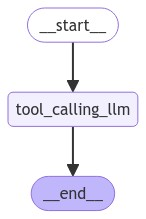

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

如果我们传入 `Hello!`，LLM 会直接响应而不调用任何工具。


In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


当LLM判定输入或任务需要某个工具提供的功能时，它会选择使用该工具。


In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Er4gChFoSGzU7lsuaGzfSGTQ)
 Call ID: call_Er4gChFoSGzU7lsuaGzfSGTQ
  Args:
    a: 2
    b: 3
